# Import Lib

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle as pk

# Import Data

In [5]:
data_file_path='/content/drive/MyDrive/Analaysis for Time Fauiler/cnc_sensor_data.csv'

In [6]:
my_data=pd.read_csv(data_file_path)

# Analyse our Data

In [327]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    1000 non-null   object 
 1   vibration    1000 non-null   float64
 2   temperature  1000 non-null   float64
 3   pressure     1000 non-null   float64
 4   status       1000 non-null   object 
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


In [328]:
my_data.head()

timestamp  vibration  temperature  pressure  status
0  2025-04-01 08:00:00       0.23         67.0      3.29  normal
1  2025-04-01 08:10:00       0.27         60.5      3.00  normal
2  2025-04-01 08:20:00       0.29         60.8      3.13  normal
3  2025-04-01 08:30:00       0.47         66.0      3.14  normal
4  2025-04-01 08:40:00       0.98         82.8      4.99   fault

In [329]:
my_data.tail()

timestamp  vibration  temperature  pressure  status
995  2025-04-08 05:50:00       0.84         78.0      4.46   fault
996  2025-04-08 06:00:00       0.24         62.8      3.47  normal
997  2025-04-08 06:10:00       0.95         78.8      4.74   fault
998  2025-04-08 06:20:00       0.21         66.9      2.84  normal
999  2025-04-08 06:30:00       0.40         63.5      3.38  normal

In [330]:
my_data.shape

(1000, 5)

In [331]:
my_data.describe(include='all')

timestamp   vibration  temperature     pressure  status
count                  1000  1000.00000  1000.000000  1000.000000    1000
unique                 1000         NaN          NaN          NaN       2
top     2025-04-08 06:30:00         NaN          NaN          NaN  normal
freq                      1         NaN          NaN          NaN     794
mean                    NaN     0.44688    68.005500     3.432790     NaN
std                     NaN     0.20736     6.615311     0.585842     NaN
min                     NaN     0.20000    60.000000     2.800000     NaN
25%                     NaN     0.30000    63.100000     3.030000     NaN
50%                     NaN     0.39500    66.300000     3.260000     NaN
75%                     NaN     0.48250    69.300000     3.450000     NaN
max                     NaN     1.00000    84.900000     5.000000     NaN

# Preprocess The Data

In [332]:
my_data["timestamp"] = pd.to_datetime(my_data["timestamp"])

In [333]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1000 non-null   datetime64[ns]
 1   vibration    1000 non-null   float64       
 2   temperature  1000 non-null   float64       
 3   pressure     1000 non-null   float64       
 4   status       1000 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 39.2+ KB


In [334]:
my_data.isna().sum()

timestamp      0
vibration      0
temperature    0
pressure       0
status         0
dtype: int64

In [335]:
my_data.duplicated().sum()

np.int64(0)

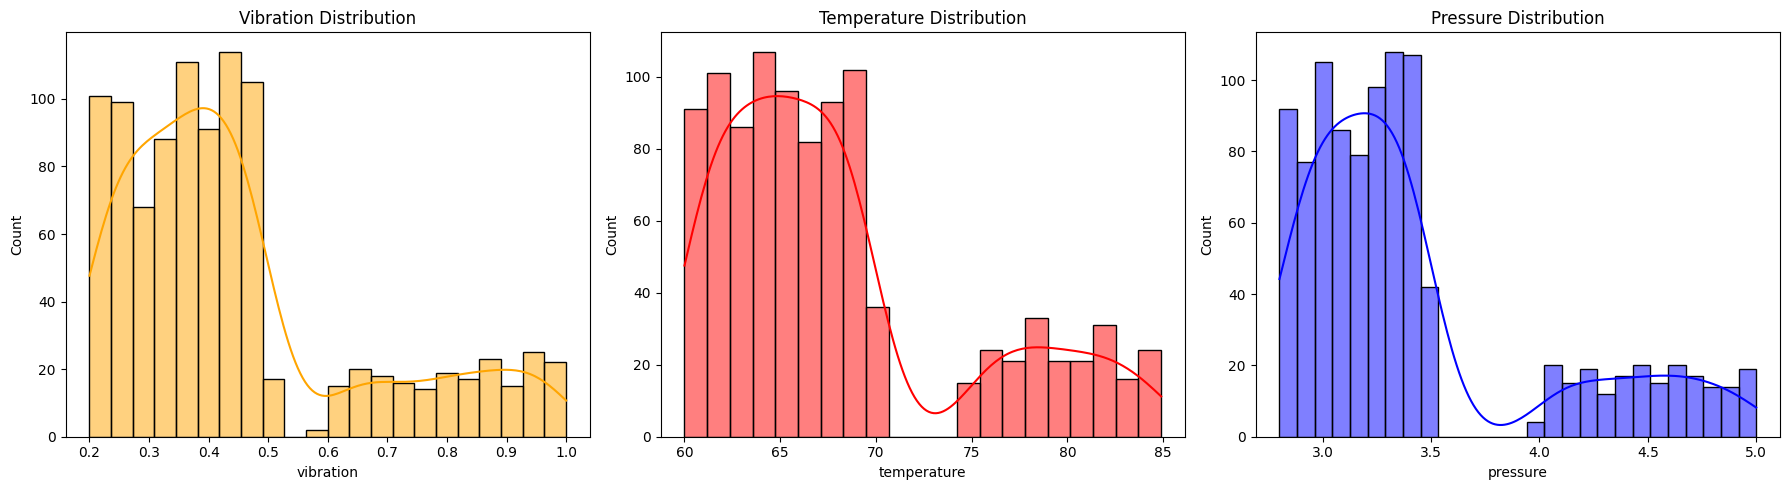

In [7]:
# رسم التوزيع لكل ميزة عددية
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(my_data["vibration"], ax=axes[0], kde=True, color="orange").set(title="Vibration Distribution")
sns.histplot(my_data["temperature"], ax=axes[1], kde=True, color="red").set(title="Temperature Distribution")
sns.histplot(my_data["pressure"], ax=axes[2], kde=True, color="blue").set(title="Pressure Distribution")

plt.tight_layout()
plt.savefig('Data_Dis.png')
plt.show()


In [337]:
features = ['vibration', 'temperature', 'pressure']
X = my_data[features]

In [338]:
model = IsolationForest(contamination=0.05, random_state=42)  # 5% شذوذ متوقعة
my_data['anomaly1'] = model.fit_predict(X)  # -1 = شاذ، 1 = طبيعي

In [339]:
my_data.anomaly1.value_counts()


anomaly1
 1    950
-1     50
Name: count, dtype: int64

In [340]:
clean_df = my_data[my_data['anomaly1'] == 1].drop(columns='anomaly1')
clean_df.shape

(950, 5)

In [341]:
features = ['vibration', 'temperature', 'pressure']
X = clean_df[features]

In [342]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
clean_df['lof_anomaly'] = lof.fit_predict(X)

In [343]:
clean_df.lof_anomaly.value_counts()

lof_anomaly
 1    902
-1     48
Name: count, dtype: int64

In [344]:
clean_df = clean_df[clean_df['lof_anomaly'] == 1].drop(columns='lof_anomaly')
clean_df.shape

(902, 5)

In [345]:
clean_df

timestamp  vibration  temperature  pressure  status
0   2025-04-01 08:00:00       0.23         67.0      3.29  normal
1   2025-04-01 08:10:00       0.27         60.5      3.00  normal
2   2025-04-01 08:20:00       0.29         60.8      3.13  normal
3   2025-04-01 08:30:00       0.47         66.0      3.14  normal
5   2025-04-01 08:50:00       0.23         69.9      3.41  normal
..                  ...        ...          ...       ...     ...
994 2025-04-08 05:40:00       0.24         67.5      3.28  normal
995 2025-04-08 05:50:00       0.84         78.0      4.46   fault
996 2025-04-08 06:00:00       0.24         62.8      3.47  normal
997 2025-04-08 06:10:00       0.95         78.8      4.74   fault
999 2025-04-08 06:30:00       0.40         63.5      3.38  normal

[902 rows x 5 columns]

# Find The Target Col

In [346]:
# إعادة حساب الوقت حتى العطل القادم لكل صف

clean_df = clean_df.sort_values("timestamp").reset_index(drop=True)
clean_df["fault_flag"] = clean_df["status"].apply(lambda x: 1 if x == "fault" else 0)

# نحسب الوقت حتى أول fault قادم
fault_indices = clean_df[clean_df["fault_flag"] == 1].index.tolist()
time_to_failure = []

for i in range(len(clean_df)):
    next_faults = [j for j in fault_indices if j >= i]
    if next_faults:
        seconds = (clean_df.loc[next_faults[0], "timestamp"] - clean_df.loc[i, "timestamp"]).total_seconds()
    else:
        seconds = None
    time_to_failure.append(seconds)

clean_df["time_to_failure"] = time_to_failure

# عرض عينة للتأكد
clean_df[["timestamp", "status", "time_to_failure"]].head(10)

timestamp  status  time_to_failure
0 2025-04-01 08:00:00  normal           7200.0
1 2025-04-01 08:10:00  normal           6600.0
2 2025-04-01 08:20:00  normal           6000.0
3 2025-04-01 08:30:00  normal           5400.0
4 2025-04-01 08:50:00  normal           4200.0
5 2025-04-01 09:00:00  normal           3600.0
6 2025-04-01 09:10:00  normal           3000.0
7 2025-04-01 09:20:00  normal           2400.0
8 2025-04-01 09:30:00  normal           1800.0
9 2025-04-01 09:40:00  normal           1200.0

In [347]:
clean_df.isna().sum()

timestamp          0
vibration          0
temperature        0
pressure           0
status             0
fault_flag         0
time_to_failure    1
dtype: int64

In [348]:
clean_df.dropna(inplace=True)

In [349]:
clean_df.isna().sum()

timestamp          0
vibration          0
temperature        0
pressure           0
status             0
fault_flag         0
time_to_failure    0
dtype: int64

In [350]:
X=clean_df.drop(columns=['time_to_failure','fault_flag','status','timestamp'])
Y=clean_df['time_to_failure']

In [351]:
X.head(20)

vibration  temperature  pressure
0        0.23         67.0      3.29
1        0.27         60.5      3.00
2        0.29         60.8      3.13
3        0.47         66.0      3.14
4        0.23         69.9      3.41
5        0.32         67.0      3.10
6        0.34         67.8      3.48
7        0.38         67.6      2.97
8        0.46         61.1      3.40
9        0.33         66.4      3.33
10       0.45         61.4      3.32
11       0.95         80.2      4.67
12       0.37         61.9      3.34
13       0.30         60.6      3.05
14       0.40         69.8      2.99
15       0.93         77.2      4.79
16       0.62         78.4      4.50
17       0.69         82.1      4.91
18       0.33         64.0      3.43
19       0.35         67.8      3.42

In [352]:
X.shape

(901, 3)

In [353]:
Y.head(20)

0     7200.0
1     6600.0
2     6000.0
3     5400.0
4     4200.0
5     3600.0
6     3000.0
7     2400.0
8     1800.0
9     1200.0
10     600.0
11       0.0
12    1800.0
13    1200.0
14     600.0
15       0.0
16       0.0
17       0.0
18    2400.0
19    1800.0
Name: time_to_failure, dtype: float64

# Split The Data And Scaling Data

In [354]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], Y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], Y.iloc[cutoff:]

In [355]:
scaler = StandardScaler()
target_scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

In [356]:
with open('Feature_Scaler.pkl', 'wb') as f:
    pk.dump(scaler, f)

In [357]:
with open('target_scaler.pkl', 'wb') as f:
    pk.dump(target_scaler, f)

In [358]:
def get_best_worst_predictions(model_name, y_true, y_pred, clean_df):
    absolute_errors = np.abs(y_true - y_pred)
    best_idx = np.argmin(absolute_errors)
    worst_idx = np.argmax(absolute_errors)

    # تحويل القيم إلى float صريح
    return {
        'model': model_name,
        'best': {
            'timestamp': clean_df.iloc[best_idx]['timestamp'],
            'actual': float(y_true[best_idx]),  # تحويل إلى float
            'predicted': float(y_pred[best_idx]),  # تحويل إلى float
            'error': float(absolute_errors[best_idx])  # تحويل إلى float
        },
        'worst': {
            'timestamp': clean_df.iloc[worst_idx]['timestamp'],
            'actual': float(y_true[worst_idx]),  # تحويل إلى float
            'predicted': float(y_pred[worst_idx]),  # تحويل إلى float
            'error': float(absolute_errors[worst_idx])  # تحويل إلى float
        }
    }

# LinearRegression

In [359]:
LR_model = LinearRegression()
LR_model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [360]:
with open('LR_model.pkl', 'wb') as f:
    pk.dump(LR_model, f)

In [361]:
LR_y_pred=LR_model.predict(x_test_scaled)
LR_mae = mean_absolute_error(y_test_scaled, LR_y_pred)
LR_rmse = np.sqrt(mean_squared_error(y_test_scaled, LR_y_pred))
LR_r2 = r2_score(y_test_scaled,LR_y_pred)

In [362]:
print(f"MAE: {LR_mae:.2f}, RMSE: {LR_rmse:.2f}, R²: {LR_r2:.4f}")

MAE: 0.60, RMSE: 0.79, R²: 0.1716


In [363]:
LR_y_true = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
LR_y_pred=target_scaler.inverse_transform(LR_y_pred.reshape(-1, 1))

In [364]:
lr_results = get_best_worst_predictions(
    "Linear Regression",
    LR_y_true,
    LR_y_pred,
    clean_df
)

<ipython-input-358-ccc3c060e742>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'actual': float(y_true[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted': float(y_pred[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'error': float(absolute_errors[best_idx])  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:17: Deprecation

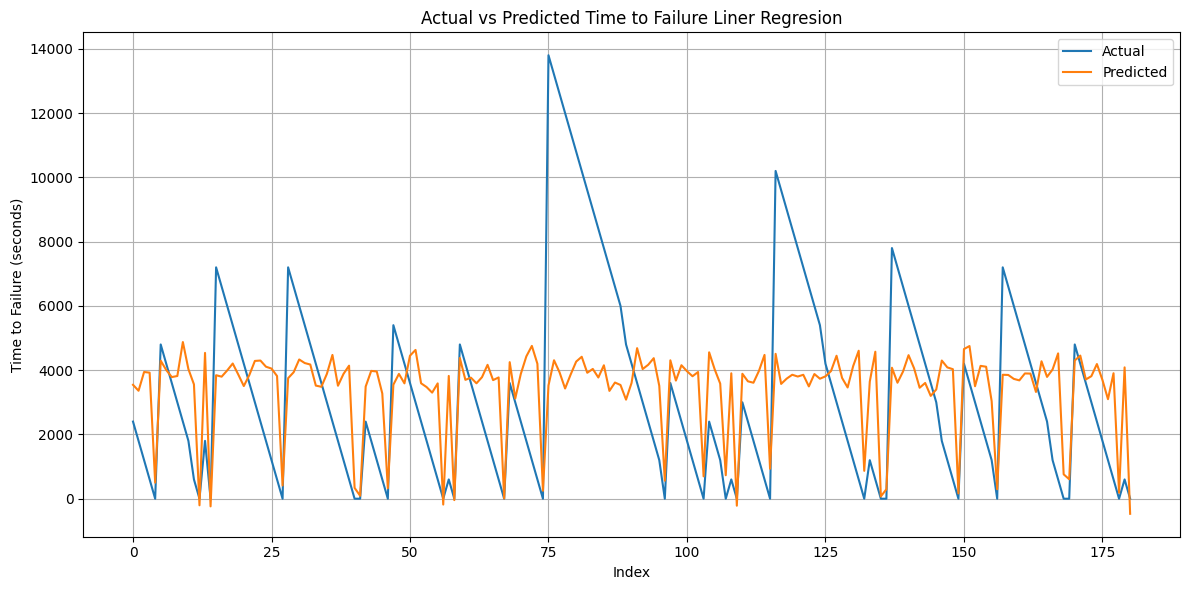

In [365]:
plt.figure(figsize=(12, 6))
plt.plot(LR_y_true, label="Actual")
plt.plot(LR_y_pred, label="Predicted")
plt.title("Actual vs Predicted Time to Failure Liner Regresion")
plt.xlabel("Index")
plt.ylabel("Time to Failure (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Liner_Regresion.png')
plt.show()

# RandomForestRegressor Model

In [366]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# # تحديد النموذج الأساسي
# model = RandomForestRegressor(random_state=42)

# # شبكة القيم لتجريبها
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # إنشاء GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1,  # استخدم كل الأنوية لتسريع العملية
#     scoring='neg_mean_squared_error',
#     verbose=2
# )

# # تدريب Grid Search
# grid_search.fit(x_train_scaled, y_train_scaled)

# # أفضل نموذج
# best_model = grid_search.best_estimator_

# # عرض أفضل الإعدادات
# print("أفضل الإعدادات:")
# print(grid_search.best_params_)


In [367]:
RF_model = RandomForestRegressor(
    n_estimators=100,     # عدد الأشجار
    max_depth=10,       # عمق الشجرة (None يعني بدون حد)
    random_state=42,
    min_samples_leaf=4,
   min_samples_split=10,
)

RF_model.fit(x_train_scaled, y_train_scaled)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [368]:
with open('RF_model.pkl', 'wb') as f:
    pk.dump(RF_model, f)

In [369]:
RF_y_pred=RF_model.predict(x_test_scaled)
RF_mae = mean_absolute_error(y_test_scaled, RF_y_pred)
RF_rmse = np.sqrt(mean_squared_error(y_test_scaled, RF_y_pred))
RF_r2 = r2_score(y_test_scaled,RF_y_pred)

In [370]:
print(f"MAE: {RF_mae:.2f}, RMSE: {RF_rmse:.2f}, R²: {RF_r2:.4f}")

MAE: 0.58, RMSE: 0.80, R²: 0.1531


In [371]:
RF_y_true = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
RF_y_pred = target_scaler.inverse_transform(RF_y_pred.reshape(-1, 1))

In [372]:
rf_results = get_best_worst_predictions(
    "Random Forest",
    RF_y_true,
    RF_y_pred,
    clean_df
)

<ipython-input-358-ccc3c060e742>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'actual': float(y_true[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted': float(y_pred[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'error': float(absolute_errors[best_idx])  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:17: Deprecation

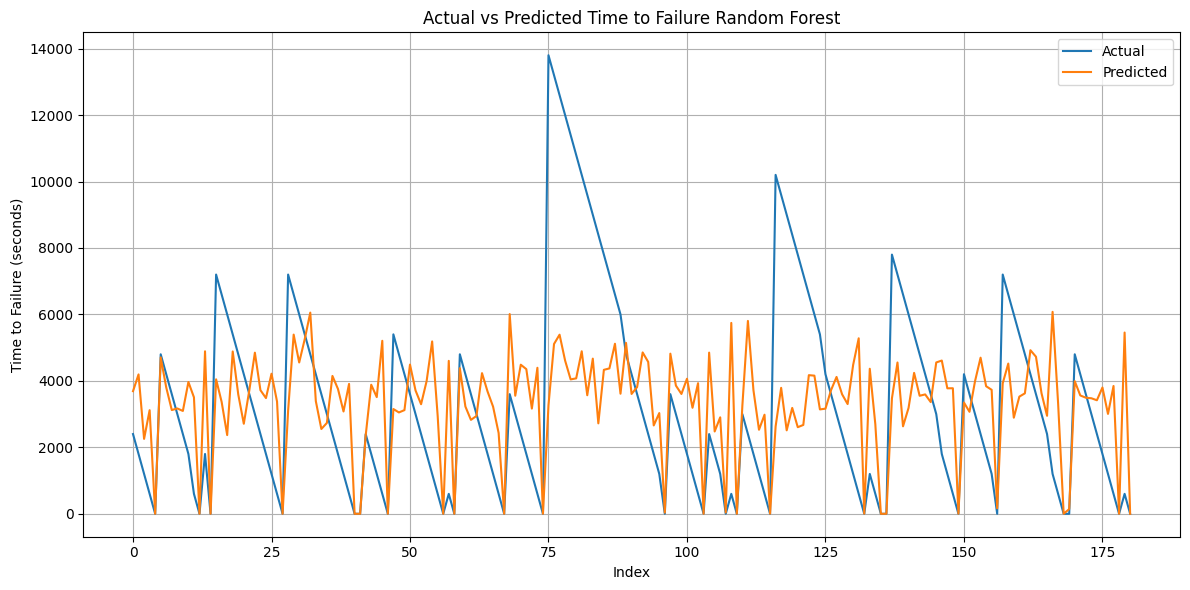

In [373]:
plt.figure(figsize=(12, 6))
plt.plot(RF_y_true, label="Actual")
plt.plot(RF_y_pred, label="Predicted")
plt.title("Actual vs Predicted Time to Failure Random Forest")
plt.xlabel("Index")
plt.ylabel("Time to Failure (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Random_Forest.png')
plt.show()

# DecisionTreeRegressor Model

In [374]:
DT_model = DecisionTreeRegressor(max_depth=5, random_state=42)
DT_model.fit(x_train_scaled, y_train_scaled)
DT_pred = DT_model.predict(x_test_scaled)

In [375]:
with open('DT_model.pkl', 'wb') as f:
    pk.dump(DT_model, f)

In [376]:
DT_mae = mean_absolute_error(y_test_scaled, DT_pred)
DT_rmse = np.sqrt(mean_squared_error(y_test_scaled, DT_pred))
DT_r2 = r2_score(y_test_scaled,DT_pred)

In [377]:
print(f"MAE: {DT_mae:.2f}, RMSE: {DT_rmse:.2f}, R²: {DT_r2:.4f}")

MAE: 0.60, RMSE: 0.82, R²: 0.1168


In [378]:
DT_y_true = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
DT_y_pred = target_scaler.inverse_transform(DT_pred.reshape(-1, 1))

In [379]:
dt_results = get_best_worst_predictions(
    "Decision Tree Regressor",
    DT_y_true,
    DT_y_pred,
    clean_df
)

<ipython-input-358-ccc3c060e742>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'actual': float(y_true[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted': float(y_pred[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'error': float(absolute_errors[best_idx])  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:17: Deprecation

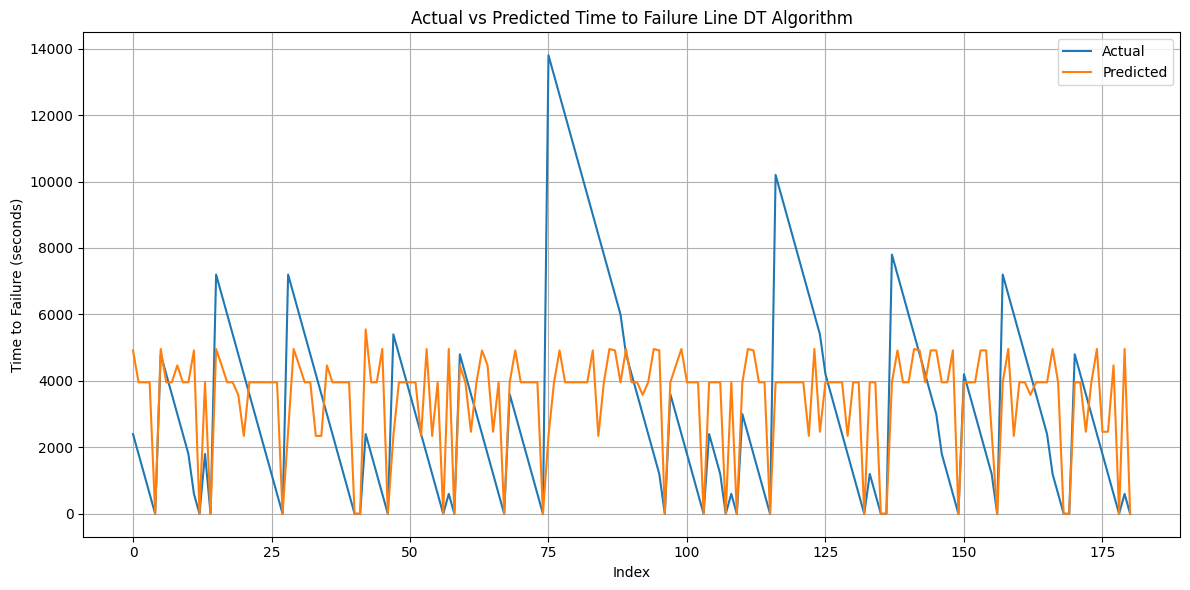

In [380]:
plt.figure(figsize=(12, 6))
plt.plot(DT_y_true, label="Actual")
plt.plot(DT_y_pred, label="Predicted")
plt.title("Actual vs Predicted Time to Failure Line DT Algorithm")
plt.xlabel("Index")
plt.ylabel("Time to Failure (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('DT.png')
plt.show()

# LSTM Model

In [381]:
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

In [382]:
seq_length = 11  # عدد الخطوات السابقة للتنبؤ
X_seq, y_seq = create_sequences(x_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(x_test_scaled, y_test_scaled, seq_length)

In [383]:
LSTM_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(seq_length, 3), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [384]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [385]:
LSTM_model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

In [386]:
LSTM_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [387]:
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # اسم ملف الحفظ
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [388]:
history = LSTM_model.fit(
    X_seq, y_seq,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2166 - mae: 0.8504
Epoch 1: val_loss improved from inf to 0.76469, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1562 - mae: 0.8296 - val_loss: 0.7647 - val_mae: 0.7146
Epoch 2/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8869 - mae: 0.7517 
Epoch 2: val_loss did not improve from 0.76469
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9435 - mae: 0.7652 - val_loss: 0.7745 - val_mae: 0.7194
Epoch 3/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0646 - mae: 0.7942 
Epoch 3: val_loss did not improve from 0.76469
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0589 - mae: 0.7936 - val_loss: 0.7756 - val_mae: 0.7228
Epoch 4/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1862 - mae: 0.8436  
Epoch 4: val_loss did not improve from 0.76469
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1346 - mae: 0.8240 - val_loss: 0.7710 - val_mae: 0.7170
Epoch 5/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9877 - mae: 0.7710  
Epoch 5: val_loss did not improve from 0.76469
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9922 - mae: 0.7

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8500 - mae: 0.7302 - val_loss: 0.7551 - val_mae: 0.7164
Epoch 9/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9186 - mae: 0.7241
Epoch 9: val_loss did not improve from 0.75513
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9170 - mae: 0.7255 - val_loss: 0.7881 - val_mae: 0.7291
Epoch 10/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8959 - mae: 0.7479
Epoch 10: val_loss did not improve from 0.75513
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8951 - mae: 0.7457 - val_loss: 0.7716 - val_mae: 0.7109
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8792 - mae: 0.7360
Epoch 11: val_loss improved from 0.75513 to 0.73350, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8790 - mae: 0.7355 - val_loss: 0.7335 - val_mae: 0.7035
Epoch 12/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8522 - mae: 0.6962
Epoch 12: val_loss did not improve from 0.73350
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8523 - mae: 0.6978 - val_loss: 0.8133 - val_mae: 0.7279
Epoch 13/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8757 - mae: 0.7218
Epoch 13: val_loss did not improve from 0.73350
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8710 - mae: 0.7197 - val_loss: 0.7782 - val_mae: 0.7255
Epoch 14/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9385 - mae: 0.7380
Epoch 14: val_loss did not improve from 0.73350
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9241 - mae: 0.7332 - val_loss: 0.7739 - val_mae: 0.7187
Epoch 15/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6065 - mae: 0.6048 
Epoch 15: val_loss did not improve from 0.73350
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6790 - ma

In [389]:
best_model = load_model('best_model.h5')

In [390]:
y_pred_scaled = best_model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [391]:
LSTM_mae = mean_absolute_error(y_true, y_pred)
LSTM_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
LSTM_r2 = r2_score(y_true, y_pred)

In [392]:
print(f"MAE: {LSTM_mae:.2f}, RMSE: {LSTM_rmse:.2f}, R²: {LSTM_r2:.4f}")

MAE: 2315.04, RMSE: 3062.93, R²: 0.0029


results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'LSTM'],
    'MAE': [mae_lr, mae_dt, mae_rf, mae_lstm],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_lstm],
    'R²': [r2_lr, r2_dt, r2_rf, r2_lstm]
})

In [393]:
lstm_results = get_best_worst_predictions(
    "LSTM",
    y_true,
    y_pred,
    clean_df
)

<ipython-input-358-ccc3c060e742>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'actual': float(y_true[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted': float(y_pred[best_idx]),  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'error': float(absolute_errors[best_idx])  # تحويل إلى float
<ipython-input-358-ccc3c060e742>:17: Deprecation

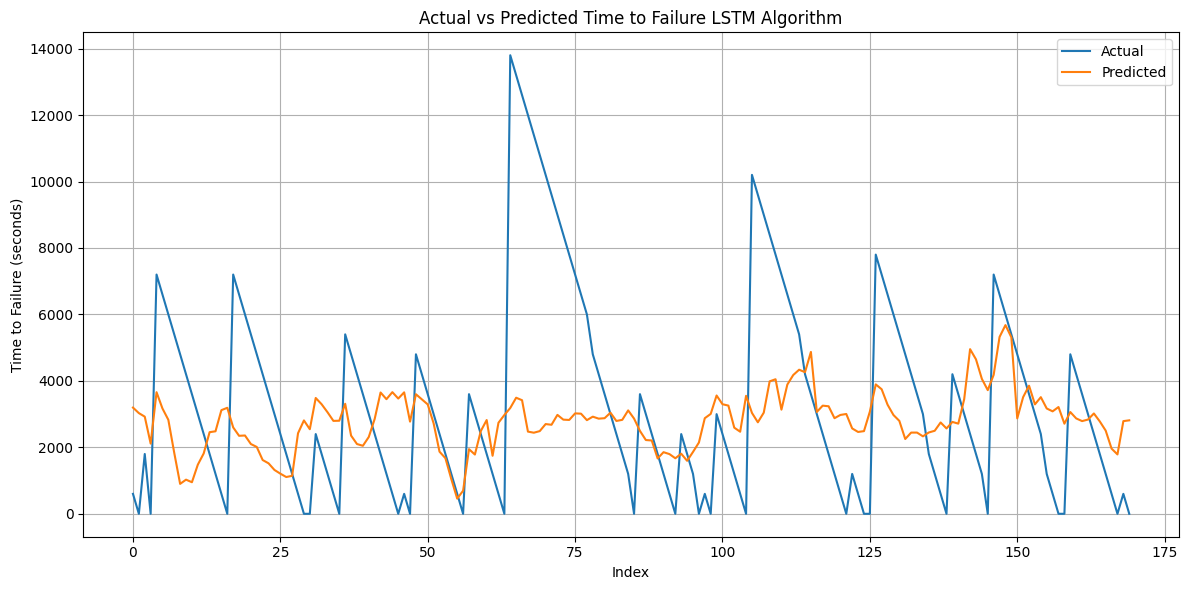

In [394]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Time to Failure LSTM Algorithm")
plt.xlabel("Index")
plt.ylabel("Time to Failure (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM.png')
plt.show()

# All Models

In [395]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'LSTM'],
    'MAE': [LR_mae, DT_mae, RF_mae, LSTM_mae],
    'RMSE': [LR_rmse, DT_rmse, RF_rmse, LSTM_rmse],
    'R²': [LR_r2, DT_r2, RF_r2, LSTM_r2]
})

In [396]:
results.to_csv('Models_Metrices.csv')

In [397]:
import pandas as pd
import os

# إنشاء المجلد إذا لم يكن موجوداً
output_dir = '/content/drive/MyDrive/Analaysis for Time Fauiler/'
os.makedirs(output_dir, exist_ok=True)

# إنشاء DataFrame
results = [rf_results, lstm_results, lr_results, dt_results]

results_df = pd.DataFrame([
    {
        'النموذج': res['model'],
        'التنبؤ الأفضل': f"{res['best']['predicted']:.2f}",
        'الخطأ في الأفضل': f"{res['best']['error']:.2f}",
        'التنبؤ الأسوأ': f"{res['worst']['predicted']:.2f}",
        'الخطأ في الأسوأ': f"{res['worst']['error']:.2f}",
        'وقت الأفضل': res['best']['timestamp'],
        'وقت الأسوأ': res['worst']['timestamp']
    }
    for res in results
])

# حفظ الملف مع إضافة التاريخ للتمييز
from datetime import datetime
filename = f"model_comparison_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
results_df.to_csv(os.path.join(output_dir, filename), index=False, encoding='utf-8-sig')

print("تم حفظ الملف بنجاح في:", os.path.join(output_dir, filename))
print("\nعرض عينة من البيانات:")
print(results_df.head())

تم حفظ الملف بنجاح في: /content/drive/MyDrive/Analaysis for Time Fauiler/model_comparison_20250419_0955.csv

عرض عينة من البيانات:
                   النموذج التنبؤ الأفضل الخطأ في الأفضل التنبؤ الأسوأ  \
0            Random Forest         -0.00            0.00       3267.32   
1                     LSTM       3042.28           42.28       3184.45   
2        Linear Regression          6.43            6.43       3525.86   
3  Decision Tree Regressor         -0.00            0.00       2344.19   

  الخطأ في الأسوأ          وقت الأفضل          وقت الأسوأ  
0        10532.68 2025-04-01 08:50:00 2025-04-01 21:20:00  
1        10615.55 2025-04-01 22:20:00 2025-04-01 19:10:00  
2        10274.14 2025-04-01 19:40:00 2025-04-01 21:20:00  
3        11455.81 2025-04-01 08:50:00 2025-04-01 21:20:00  
